## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras

In [3]:
from keras import Sequential
from keras.layers import BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D, Dense, Input, ZeroPadding2D, Activation, MaxPooling2D, Add,AveragePooling2D
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import RMSprop
from keras.datasets import mnist
from keras import Model
from keras.callbacks import ReduceLROnPlateau

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [5]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import Dataset


In [6]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

In [7]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y = train.label
train = train.drop(columns='label')

In [9]:
print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')

Train Shape: (42000, 784)
Test Shape: (28000, 784)


In [10]:
train = train/255
test = test/255

### PCA

In [11]:
# # Standardize the data
# StdSc = StandardScaler()
# X_std = StdSc.fit_transform(train.values)

# # Calculating Eigenvectors and eigenvalues of Cov matirx
# mean_vec = np.mean(X_std, axis=0)
# cov_mat = np.cov(X_std.T)
# eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# # Create a list of (eigenvalue, eigenvector) tuples
# eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# # Sort the eigenvalue, eigenvector pair from high to low
# eig_pairs.sort(key = lambda x: x[0], reverse= True)

# # Calculation of Explained Variance from the eigenvalues
# tot = sum(eig_vals)
# var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
# cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
# plt.plot(cum_var_exp)

In [12]:
# from sklearn.decomposition import PCA

In [13]:
# #Standardize training before PCA
# StdSc = StandardScaler()
# train_std = StdSc.fit_transform(train.values)
# pca = PCA(200)
# train_decom = pca.fit_transform(train_std)
# train_recon = pca.inverse_transform(train_decom)

In [14]:
# for i in range(0,5,1):
#     plt.subplot(1,2,1)
#     plt.imshow(train.values[i].reshape(28,28), cmap='jet')
#     plt.subplot(1,2,2)
#     plt.imshow(train_recon[i].reshape(28,28), cmap='jet')
#     plt.show()

### ResNet

In [15]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    #Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [16]:
def convolutional_block(X, f, filters, stage, block, s = 1):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    


    # Second component of main path
    X = Conv2D(F2, (f,f), strides =(1,1), padding = 'same', name = conv_name_base+'2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'same', name = conv_name_base+'2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'same', name = conv_name_base+'1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base+'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

In [17]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (28, 28, 1), classes = 10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')
    X = identity_block(X, 3, [64, 64, 64], stage = 2, block='d')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 128], stage = 3, block = 'a', s = 1)
    X = identity_block(X, 3, [64, 64, 128], stage = 3, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage = 3, block='c')
    X = identity_block(X, 3, [64, 64, 128], stage = 3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 4, block = 'a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage = 4, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage = 4, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage = 4, block='d')


    # AVGPOOL 
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [18]:
model = ResNet50(input_shape = (28, 28, 1), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [20]:
train = train.to_numpy().reshape(-1,28,28,1)
test = test.to_numpy().reshape(-1,28,28,1)

In [21]:
y = to_categorical(y, num_classes = 10)
X_train, X_val, Y_train, Y_val = train_test_split(train, y, test_size = 0.1, random_state=2)

In [22]:
StdSc_2 = StandardScaler()
X_train = StdSc_2.fit_transform(X_train)
X_val = StdSc_2.transform(X_val)

In [23]:
# X_train = X_train.reshape(-1,28,28,1)
# X_val = X_val.reshape(-1,28,28,1)

In [24]:
#Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

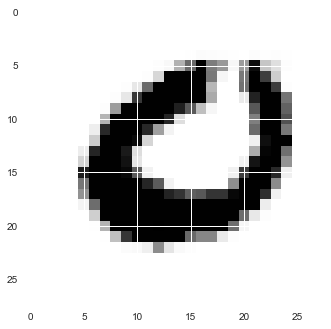

In [25]:
g = plt.imshow(X_train[180][:,:,0])

In [26]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# # from IPython.display import Image
# # Image("model.png")

In [27]:
# X_train.shape

In [28]:
# Y_train.shape

In [29]:
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [30]:
epochs = 40
batch_size = 128
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=(len(X_train) // batch_size), 
                    epochs=epochs, 
                    callbacks=[lrr])

Epoch 1/40
295/295 [==============================] - 23s 61ms/step - loss: 0.4531 - accuracy: 0.8582 - val_loss: 7.5998 - val_accuracy: 0.1186
Epoch 2/40
295/295 [==============================] - 17s 59ms/step - loss: 0.1052 - accuracy: 0.9688 - val_loss: 0.1357 - val_accuracy: 0.9590
Epoch 3/40
295/295 [==============================] - 17s 59ms/step - loss: 0.0805 - accuracy: 0.9761 - val_loss: 0.0985 - val_accuracy: 0.9724
Epoch 4/40
295/295 [==============================] - 18s 60ms/step - loss: 0.0638 - accuracy: 0.9817 - val_loss: 0.0996 - val_accuracy: 0.9726
Epoch 5/40
295/295 [==============================] - 18s 60ms/step - loss: 0.0576 - accuracy: 0.9823 - val_loss: 0.0987 - val_accuracy: 0.9693
Epoch 6/40
295/295 [==============================] - 18s 61ms/step - loss: 0.0560 - accuracy: 0.9837 - val_loss: 0.0402 - val_accuracy: 0.9883
Epoch 7/40
295/295 [==============================] - 18s 59ms/step - loss: 0.0491 - accuracy: 0.9857 - val_loss: 0.0562 - val_accuracy:

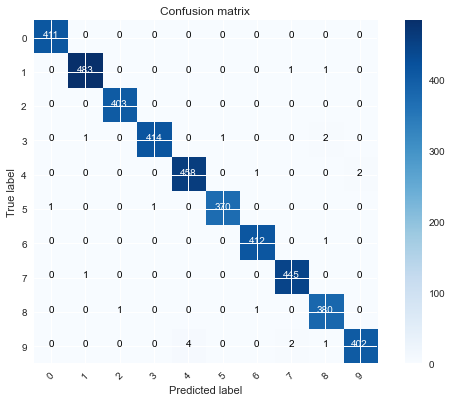

In [31]:
# Draw a confusion matrix that can be used to observe high false positives
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

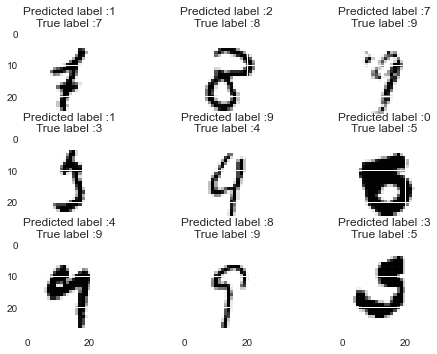

In [32]:
# Show some wrong results, and the difference between the predicted label and the real labe
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [33]:
yhat_train = model.predict(X_train)
yhat_train_classes = np.argmax(yhat_train,axis = 1) 
yhat_val = model.predict(X_val)
yhat_val_classes = np.argmax(yhat_val,axis = 1) 
y_train = np.argmax(Y_train,axis = 1) 
y_val = np.argmax(Y_val,axis = 1) 

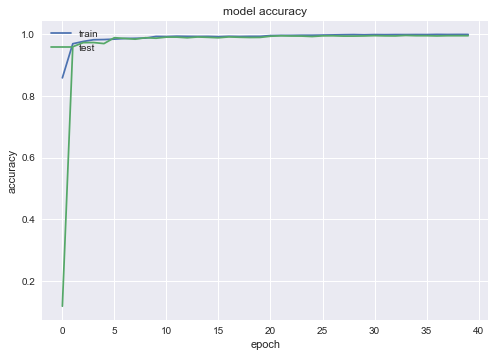

In [34]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

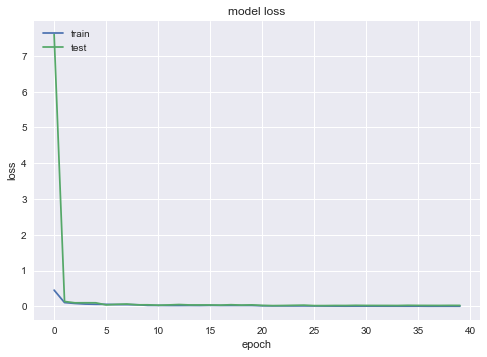

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
print(f'Training Accuracy : {(accuracy_score(yhat_train_classes, y_train)*100):.5}%')
print(f'Validation Accuracy : {(accuracy_score(yhat_val_classes, y_val)*100):.5}%')

Training Accuracy : 99.947%
Validation Accuracy : 99.476%


In [37]:
test = pd.read_csv('../test.csv')
# test=test/255
# #Standardize training before PCA
# X_std_test = StandardScaler().fit_transform(test.values)
# pca = PCA(200)
# decom_test = pca.fit_transform(X_std_test)
# recon_test = pca.inverse_transform(decom_test)

In [38]:
# recon_test = recon_test.reshape(-1,28,28,1)
# Make predictions about test sets

# test_decom = pca.transform(test_std)
# test_recon = pca.inverse_transform(test_decom)
# test_recon = StdSc_2.transform(test_recon)
test = test.to_numpy().reshape(-1,28,28,1)
test = stdsc.transform(test)
results = model.predict(test)

# Convert one-hot vector to number
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [39]:
# Save the final result in cnn_mnist_submission.csv
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission_v16.csv",index=False)

In [40]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
